In [ ]:
# Version V1.1:
# Separate file for segmentation re-do. Multiple files can be re-segmented at the same time using modelNames. 
# Script loops through all datapaths and modelNames. 

## surface segmentation using ilastik, from h5 files

In [1]:
import ilastik.experimental.api
from ilastik.experimental.api import from_project_file
from xarray import DataArray

#### Load Libraries

In [2]:
# The environment to use here is: celltraj_env
#%%capture
import matplotlib
import matplotlib.pyplot as plt
import numpy as np
import sys
sys.path.insert(0,'/mnt/c/Users/copperma/OneDrive/Documents/cell/celltraj/celltraj')
import trajectory
import imageprep as imprep
import utilities
import features
import model
import h5py
import pickle
import os
import subprocess
import time
#import bootstrap
import umap
import pyemma.coordinates as coor
import scipy
import csaps
import skimage
from IPython.display import clear_output
import os
from scipy.sparse import csr_matrix
from scipy.sparse.csgraph import connected_components
np.float=np.dtype(float)
np.int=int
import msmtools
import pandas
import itertools
import ray

Solver suite is petsc


#### Load File Details

In [3]:
#%%capture

# This date is to make folders of analysis based off the date you do the analysis. 
date = '5dec24'
os.system(f'mkdir -p {date}')

# Make sure the model names are correct since these are what the file names have been called. If you want to rename
# the files, use script 'file_rename'
modelNames = [f'20241004_OS17lungInh2_RM'] 

datapaths=['/home/groups/CEDAR/copperma/dyn-cell-sys/makkawi/20241004_OS17lungInh2_RM']

#### Loop through the segmented files

In [4]:
#%%capture
import imageprep as imprep
import itertools

modelLists = [None]*len(modelNames)
inds_imagingSet=[]
for idataset in range(len(modelNames)):
    modelLists[idataset]=imprep.list_images(f'{datapaths[idataset]}/{modelNames[idataset]}_xy*_roi*.h5')
    inds_dataset=[idataset]*len(modelLists[idataset])
    inds_imagingSet.append(inds_dataset)

inds_imagingSet=list(itertools.chain(*inds_imagingSet))

for ilist in range(len(modelLists)):
    print(f'movies: {modelLists[ilist]}')

movies: ['/home/groups/CEDAR/copperma/dyn-cell-sys/makkawi/20241004_OS17lungInh2_RM/20241004_OS17lungInh2_RM_xy0_roi0.h5', '/home/groups/CEDAR/copperma/dyn-cell-sys/makkawi/20241004_OS17lungInh2_RM/20241004_OS17lungInh2_RM_xy10_roi0.h5', '/home/groups/CEDAR/copperma/dyn-cell-sys/makkawi/20241004_OS17lungInh2_RM/20241004_OS17lungInh2_RM_xy11_roi0.h5', '/home/groups/CEDAR/copperma/dyn-cell-sys/makkawi/20241004_OS17lungInh2_RM/20241004_OS17lungInh2_RM_xy12_roi0.h5', '/home/groups/CEDAR/copperma/dyn-cell-sys/makkawi/20241004_OS17lungInh2_RM/20241004_OS17lungInh2_RM_xy13_roi0.h5', '/home/groups/CEDAR/copperma/dyn-cell-sys/makkawi/20241004_OS17lungInh2_RM/20241004_OS17lungInh2_RM_xy14_roi0.h5', '/home/groups/CEDAR/copperma/dyn-cell-sys/makkawi/20241004_OS17lungInh2_RM/20241004_OS17lungInh2_RM_xy15_roi0.h5', '/home/groups/CEDAR/copperma/dyn-cell-sys/makkawi/20241004_OS17lungInh2_RM/20241004_OS17lungInh2_RM_xy16_roi0.h5', '/home/groups/CEDAR/copperma/dyn-cell-sys/makkawi/20241004_OS17lungInh2_

#### Surface segmentation

In [5]:
def get_surf_fmask_lung_cancer(img_ilastik,ilastik_model,cdict_ilp,cdict_surf,histp=None,sigma=5,thresh=0.2,return_prediction=False):
    image = DataArray(img_ilastik, dims=("y", "x", "c"))
    prediction = ilastik_model.predict(image)
    prediction=prediction.to_numpy()
    for ichannel in range(prediction.shape[2]):
        pred=prediction[...,ichannel]
        if sigma is not None:
            pred=scipy.ndimage.gaussian_filter(pred,sigma=sigma)
        if histp is not None:
            plow, phigh = np.percentile(pred, (histp[0], histp[1]))
            pred=(pred-plow)/(phigh-plow)
        prediction[...,ichannel]=pred
    max_pred=np.argmax(prediction,axis=2)
    fmasks=np.zeros((img_ilastik.shape[0],img_ilastik.shape[1],2)).astype(bool)
    fmasks[...,0]=(prediction[...,cdict_ilp['lung']]-prediction[...,cdict_ilp['airway']]>thresh)
    fmasks[...,1]=(prediction[...,cdict_ilp['live-cancer']]+prediction[...,cdict_ilp['dead-cancer']]-prediction[...,cdict_ilp['lung']]-prediction[...,cdict_ilp['airway']]>thresh)
    if return_prediction:
        return prediction,fmasks
    else:
        return fmasks
    return fmasks

In [20]:
def show_3dseg_proj(fig,im3d,labels,surfaces=None,surf_cmaps=None,labels2=None,fmsk=None,zscale=None,label_color='black',label2_color='red',img_cmap=plt.cm.gray_r):
    if zscale is not None:
        im3d=skimage.transform.rescale(im3d,(zscale,1,1),anti_aliasing=False)
        labels=skimage.transform.rescale(labels,(zscale,1,1),order=0)
        for isurf in range(len(surfaces)):
            surfaces[isurf]=skimage.transform.rescale(surfaces[isurf],(zscale,1,1),order=0)
        if labels2 is not None:
            labels2=skimage.transform.rescale(labels2,(zscale,1,1),order=0)
    if surf_cmaps is None and surfaces is not None:
        print(len(surfaces))
        surf_cmaps=[plt.cm.Blues,plt.cm.Greens,plt.cm.Reds,plt.cm.Purples,plt.cm.Oranges,plt.cm.Blues,plt.cm.Greens]
    if label_color is None:
        label_color='black'
    if label2_color is None:
        label2_color='red'
    if img_cmap is None:
        img_cmap=plt.cm.gray_r
    zproj=np.sum(im3d,axis=0)
    xproj=np.sum(im3d,axis=1)
    yproj=np.sum(im3d,axis=2)
    labels_zproj=np.max(labels,axis=0)
    labels_xproj=np.max(labels,axis=1)
    labels_yproj=np.max(labels,axis=2)
    plt.subplot(1,3,1)
    plt.imshow(zproj,cmap=img_cmap)
    plt.contour(labels_zproj,levels=np.arange(np.max(labels_zproj)),colors=label_color,linewidths=1)
    if surfaces is not None:
        for isurf in range(len(surfaces)):
            surf_viz=np.sum(surfaces[isurf],axis=0)
            plt.imshow(np.ma.masked_where(np.logical_not(surf_viz>0),surf_viz),alpha=.3,cmap=surf_cmaps[isurf])#,clim=(0,1))
    if labels2 is not None:
        labels2_zproj=np.max(labels2,axis=0)
        plt.contour(labels2_zproj,levels=np.arange(np.max(labels2_zproj)),colors=label2_color,linewidths=1)  
    plt.axis('equal');plt.axis('off')
    plt.subplot(1,3,2)
    plt.imshow(xproj,cmap=img_cmap)
    plt.contour(labels_xproj,levels=np.arange(np.max(labels_xproj)),colors=label_color,linewidths=1)
    if surfaces is not None:
        for isurf in range(len(surfaces)):
            surf_viz=np.sum(surfaces[isurf],axis=1)
            plt.imshow(np.ma.masked_where(np.logical_not(surf_viz>0),surf_viz),alpha=.3,cmap=surf_cmaps[isurf])#,clim=(0,1))
    if labels2 is not None:
        labels2_xproj=np.max(labels2,axis=1)
        plt.contour(labels2_xproj,levels=np.arange(np.max(labels2_xproj)),colors=label2_color,linewidths=1)
    plt.axis('equal');plt.axis('off')
    plt.subplot(1,3,3)
    plt.imshow(yproj,cmap=img_cmap)
    plt.contour(labels_yproj,levels=np.arange(np.max(labels_yproj)),colors=label_color,linewidths=1)
    if labels2 is not None:
        labels2_yproj=np.max(labels2,axis=2)
        plt.contour(labels2_yproj,levels=np.arange(np.max(labels2_yproj)),colors=label2_color,linewidths=1)
    if surfaces is not None:
        for isurf in range(len(surfaces)):
            surf_viz=np.sum(surfaces[isurf],axis=2)
            plt.imshow(np.ma.masked_where(np.logical_not(surf_viz>0),surf_viz),alpha=.3,cmap=surf_cmaps[isurf])#,clim=(0,1)) 
    plt.axis('equal');plt.axis('off')

In [7]:
cdict_ilp={'dead-cancer':0,'live-cancer':1,'lung':2,'airway':3}
cdict_surf={'cancer':0,'lung':1,'airway':2,'dead':3}
fmask_channels=['foreground','nuc','lung','cancer']

n_fmasks=2
ndimage=scipy.ndimage
nucl=25                                 #typical nucleus linear diameter pixels
micron_per_pixel=.33                    #lateral resolution (image pixel size)
micron_per_z=3.0                        #axial resolution between z-slices
nucl=25
rsmooth=nucl/4
thresh=0.2
zscale=micron_per_z/micron_per_pixel

ilastik_modelpath='/home/groups/CEDAR/copperma/dyn-cell-sys/makkawi/20241004_OS17lungInh2_RM/Death2/20241023_death_identification_RM_16nov24.ilp'
ilastik_model = from_project_file(ilastik_modelpath)

vizpath='/home/groups/CEDAR/copperma/dyn-cell-sys/makkawi/20241004_OS17lungInh2_RM/20241208_surfseg'
pathexists = os.path.isdir(vizpath)     #create image folder if it doesn't exist already
if not pathexists:
    os.mkdir(vizpath)
    
visual=True
modelList_flat=list(itertools.chain(*modelLists))

2


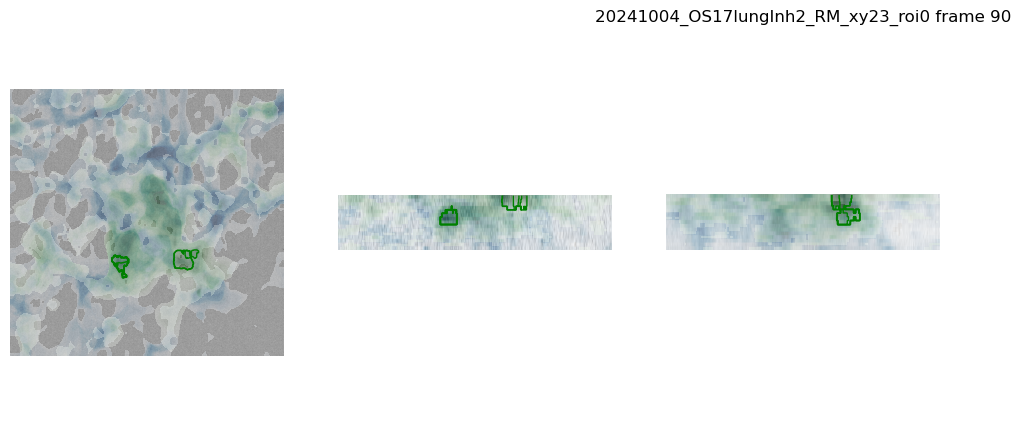

/images/img_91/fmsk shape (15, 671, 688, 2)
getting foreground mask from /home/groups/CEDAR/copperma/dyn-cell-sys/makkawi/20241004_OS17lungInh2_RM/20241004_OS17lungInh2_RM_xy23_roi0.h5 fmask channel 0
getting foreground mask from /home/groups/CEDAR/copperma/dyn-cell-sys/makkawi/20241004_OS17lungInh2_RM/20241004_OS17lungInh2_RM_xy23_roi0.h5 fmask channel 1
getting ilastik prediction frame 91 slice 0 of 15
getting ilastik prediction frame 91 slice 1 of 15
getting ilastik prediction frame 91 slice 2 of 15
getting ilastik prediction frame 91 slice 3 of 15
getting ilastik prediction frame 91 slice 4 of 15


In [ ]:
# Actual surface segmentation
modelList_flat=list(itertools.chain(*modelLists))
modelSet=[None]*len(modelList_flat)
for i in [15,26,27,32]: #range(len(modelList_flat)): 
    try:
        h5filename=modelList_flat[i]
        modelSet[i]=trajectory.Trajectory(h5filename=h5filename)
        sctm=modelSet[i]
        moviename=sctm.figid.decode() #unique for each h5 file
        #status=modelSet[i].load_from_h5('/cell_data_m0/')
        modelSet[i].get_image_shape()                             #some missing info, add in to metadata in future
        fore_fmsk_channel=np.where(sctm.fmask_channels==np.array(['foreground']).astype('S32'))[0][0]
        try:
            nuc_fmsk_channel=np.where(sctm.fmask_channels==np.array(['nuc']).astype('S32'))[0][0]
            nuc_fmsk_channel=np.where(sctm.fmask_channels==np.array(['fore']).astype('S32'))[0][0]
            nuc_msk_channel=None
            fore_msk_channel=None
        except Exception as e:
            print(e)
            nuc_msk_channel=np.where(sctm.mask_channels==np.array(['nuc']).astype('S32'))[0][0]
            fore_msk_channel=np.where(sctm.mask_channels==np.array(['nuc']).astype('S32'))[0][0]
            nuc_fmsk_channel=None
            fore_fmsk_channel=None
        cyto_msk_channel=np.where(sctm.mask_channels==np.array(['cyto']).astype('S32'))[0][0]
        nuc_img_channel=np.where(sctm.channels==np.array(['DAPI']).astype('S32'))[0][0]
        rep_img_channel=np.where(sctm.channels==np.array(['YFP']).astype('S32'))[0][0]
        bf_img_channel=np.where(sctm.channels==np.array(['BF']).astype('S32'))[0][0]
        erk_img_channel=np.where(sctm.channels==np.array(['YFP']).astype('S32'))[0][0]
        akt_img_channel=np.where(sctm.channels==np.array(['TRITC']).astype('S32'))[0][0]
        fra1_img_channel=np.where(sctm.channels==np.array(['CFP']).astype('S32'))[0][0]
        mskchannel=cyto_msk_channel
        sctm.mskchannel=0
        nt_roi=sctm.nt;nx_roi=sctm.nx;ny_roi=sctm.ny;nz_roi=sctm.nz
        sctm.ilastik_modelpath=ilastik_modelpath
        sctm.fmask_channels=fmask_channels
        sctm.save_to_h5('/metadata/',['ilastik_modelpath','fmask_channels'],overwrite=True)
        print(f'loaded {sctm.h5filename} with {sctm.mask_channels} mask channels, {sctm.channels} image channels, cell index on {mskchannel}') 
        nuc_channel=nuc_img_channel
        rep_channel=erk_img_channel
        bf_channel=bf_img_channel
        for iS in range(nt_roi):
            fstr=f'/images/img_{iS}/fmsk'
            with h5py.File(h5filename,'r') as h:
                try:
                    fmsk_df=h[fstr]
                    print(f'{fstr} shape {fmsk_df[...].shape}')
                    fmsk_dim=fmsk_df[...].shape[3]
                except Exception as e:
                    print(e)
                    fmsk_dim=0
            if fmsk_dim!=4:
                img=sctm.get_image_data(iS)
                msk=sctm.get_mask_data(iS)
                if nuc_fmsk_channel is not None:
                    fmsk_fore=sctm.get_fmask_data(iS,channel=fore_fmsk_channel)
                    fmsk_nuc=sctm.get_fmask_data(iS,channel=nuc_fmsk_channel)
                else:
                    fmsk_fore=msk[...,fore_msk_channel]>0
                    fmsk_nuc=msk[...,nuc_msk_channel]>0
                im3d_nuc=utilities.rescale_to_int(imprep.znorm(img[...,nuc_channel]))
                im3d_rep=utilities.rescale_to_int(imprep.znorm(img[...,rep_channel]))
                im3d_bf=imprep.znorm(img[...,bf_channel])
                im3d_bf=skimage.filters.difference_of_gaussians(im3d_bf,.5,1.5)
                im3d_bf=utilities.rescale_to_int(im3d_bf)
                cellpose_img=np.zeros((nz_roi,3,nx_roi,ny_roi)).astype(np.uint16)
                cellpose_img[:,0,:,:]=im3d_bf #add in nuc so not hollow
                cellpose_img[:,1,:,:]=im3d_rep
                cellpose_img[:,2,:,:]=im3d_nuc
                fmasks=np.zeros((nz_roi,nx_roi,ny_roi,n_fmasks)).astype(bool)
                predictions=np.zeros((nz_roi,nx_roi,ny_roi,len(cdict_ilp)))
                for iz in range(nz_roi):
                    print(f'getting ilastik prediction frame {iS} slice {iz} of {nz_roi}')
                    img_ilastik=cellpose_img[iz,...]
                    img_ilastik=np.swapaxes(img_ilastik,0,2);img_ilastik=np.swapaxes(img_ilastik,0,1)
                    predictions[iz,...],fmasks[iz,...]=get_surf_fmask_lung_cancer(img_ilastik,ilastik_model,cdict_ilp,cdict_surf,sigma=rsmooth,thresh=thresh,return_prediction=True)
                #predictions=(predictions*(2**16-1)).astype(int)
                #img=np.concatenate((img,predictions),axis=3)
                #img=np.concatenate((img[...,0:len(sctm.channels)],predictions[...,0][...,np.newaxis]),axis=3)
                fmsks=np.concatenate((fmsk_fore[...,np.newaxis],fmsk_nuc[...,np.newaxis],fmasks),axis=3)
                imprep.save_frame_h5(sctm.h5filename,iS,img=img,msks=msk,fmsk=fmsks,overwrite=True,timestamp=None)
                if visual:
                    clear_output(wait=True)
                    show_3dseg_proj(plt.figure(figsize=(12,5)),img[...,erk_img_channel],msk[...,0],surfaces=[fmsks[...,2],fmsks[...,3]],zscale=sctm.zscale,label_color='green')
                    plt.title(f'{moviename} frame {iS}')
                    plt.savefig(f'{vizpath}/surf_proj_{moviename}_f{iS}.png')
                    plt.show()
    except Exception as e:
        print(e)
        pass

### featurize and track, including MVE boundary features

In [19]:
#@ray.remote(num_cpus=4)
def get_cellfeatures_distributed(h5filename):
    output_message=f'featurizing {h5filename}...'
    try:
        sctm=trajectory.Trajectory(h5filename=h5filename)
        sctm.get_image_shape()
        print(f'{sctm.nmaskchannels}')
        cyto_msk_channel=np.where(sctm.mask_channels==np.array(['cyto']).astype('S32'))[0][0]
        nuc_img_channel=np.where(sctm.channels==np.array(['DAPI']).astype('S32'))[0][0]
        rep_img_channel=np.where(sctm.channels==np.array(['YFP']).astype('S32'))[0][0]
        bf_img_channel=np.where(sctm.channels==np.array(['BF']).astype('S32'))[0][0]
        erk_img_channel=np.where(sctm.channels==np.array(['YFP']).astype('S32'))[0][0]
        akt_img_channel=np.where(sctm.channels==np.array(['TRITC']).astype('S32'))[0][0]
        fra1_img_channel=np.where(sctm.channels==np.array(['CFP']).astype('S32'))[0][0]
        foreground_fmskchannel=np.where(sctm.fmask_channels==np.array(['foreground']).astype('S32'))[0][0]
        nuc_fmskchannel=np.where(sctm.fmask_channels==np.array(['nuc']).astype('S32'))[0][0]
        mskchannel=cyto_msk_channel; sctm.mskchannel=mskchannel
        #sctm.load_from_h5('/cell_data_m{sctm.mskchannel}/')
        #output_message=f'{output_message} loaded cell data...'
        sctm.get_frames()
        sctm.get_cell_index(verbose=True,save_h5=True,overwrite=True)
        ntrans=[1,1,1]
        maxt=[0.,0.,0.]
        tf_matrix_set=sctm.get_stack_trans(mskchannel=sctm.mskchannel,ntrans=ntrans,maxt=maxt,dist_function=utilities.get_pairwise_distance_sum,save_h5=True,overwrite=True,do_global=False) #,contact_transform=True,r0=100.,d0=100.,n=6,m=12)
        clear_output(wait=True)
        x=sctm.get_cell_positions(mskchannel=sctm.mskchannel,save_h5=True,overwrite=True)
        clear_output(wait=True)
        tf_matrix_set_pad,pad_dims=imprep.get_registration_expansions(sctm.tf_matrix_set,sctm.nz,sctm.nx,sctm.ny)
        sctm.pad_dims=np.array(pad_dims)
        sctm.save_to_h5(f'/cell_data_m{mskchannel}/',['pad_dims'])
        clear_output(wait=True)
        ot_costs,linSet=sctm.get_lineage_min_otcost(distcut=0.5*sctm.cellpose_diam,return_cost=True,ot_cost_cut=np.inf,border_resolution=1.33,visual=False,save_h5=True,overwrite=True)
        output_message=f'{output_message} tracked...'
        clear_output(wait=True)
        #Bright field features with cyto masks
        Xf,feature_list=sctm.get_cell_features((features.featZernike,features.featHaralick,features.featBoundary),indcells=None,imgchannel=bf_img_channel,mskchannel=cyto_msk_channel,return_feature_list=True,save_h5=True,overwrite=True)
        #foreground mask boundary features
        clear_output(wait=True)
        bordersize=int(sctm.cellpose_diam/5.)
        Xf,feature_list=sctm.get_cell_features((features.featBoundaryCB),indcells=None,imgchannel=0,mskchannel=cyto_msk_channel,use_fmask_for_intensity_image=True,fmskchannel=foreground_fmskchannel,bordersize=bordersize,return_feature_list=True,save_h5=True,overwrite=True,concatenate_features=True)
        clear_output(wait=True)
        #boundary features to monitor cancer cell neighbors
        Xf,feature_list=sctm.get_cell_features((features.featBoundaryCB),indcells=None,use_mask_for_intensity_image=True,apply_contact_transform=True,bordersize=int(bordersize/2),imgchannel=cyto_msk_channel,mskchannel=cyto_msk_channel,return_feature_list=True,save_h5=True,overwrite=True,concatenate_features=True)
        output_message=f'{output_message} bf features...'
        clear_output(wait=True)
        #motility features
        #Xf_com=sctm.get_motility_features(mskchannel=cyto_msk_channel,save_h5=True,overwrite=True)
        #output_message=f'{output_message} motility features...'
        clear_output(wait=True)
        #signaling features
        corrc_erk=sctm.get_cell_channel_crosscorr(mskchannel=cyto_msk_channel,imgchannel1=nuc_img_channel,imgchannel2=erk_img_channel,save_h5=True,overwrite=True)
        corrc_erk=1.-corrc_erk
        clear_output(wait=True)
        cratio_erk=sctm.get_cell_compartment_ratio(imgchannel=erk_img_channel,mskchannel1=cyto_msk_channel,mskchannel2=None,fmask_channel=nuc_fmskchannel,make_disjoint=True,remove_background_perframe=True,inverse_ratio=False,save_h5=True,overwrite=True)
        clear_output(wait=True)
        corrc_akt=sctm.get_cell_channel_crosscorr(mskchannel=cyto_msk_channel,imgchannel1=nuc_img_channel,imgchannel2=akt_img_channel,save_h5=True,overwrite=True)
        corrc_akt=1.-corrc_akt
        clear_output(wait=True)
        cratio_akt=sctm.get_cell_compartment_ratio(imgchannel=akt_img_channel,mskchannel1=cyto_msk_channel,mskchannel2=None,fmask_channel=nuc_fmskchannel,remove_background_perframe=True,make_disjoint=True,inverse_ratio=False,save_h5=True,overwrite=True)
        clear_output(wait=True)
        output_message=f'{output_message} signaling features...'
        #nuclear features with cyto masks
        Xf1,feature_list1=sctm.get_cell_features((features.featZernike,features.featHaralick),indcells=None,imgchannel=nuc_img_channel,mskchannel=cyto_msk_channel,return_feature_list=True)
        #nuclear shape features with cyto masks, nuc masks as intensity image
        Xf2,feature_list2=sctm.get_cell_features((features.featNucBoundary),mskchannel=cyto_msk_channel,indcells=None,use_fmask_for_intensity_image=True,fmskchannel=nuc_fmskchannel,return_feature_list=True)
        nucintensity_DAPI=sctm.get_cell_compartment_ratio(imgchannel=nuc_img_channel,mskchannel1=cyto_msk_channel,mskchannel2=None,fmask_channel=nuc_fmskchannel,make_disjoint=True,remove_background_perframe=True,inverse_ratio=True,noratio=True)
        #cyto mask with reporter channel features
        Xf3,feature_list3=sctm.get_cell_features((features.featSize,features.meanIntensity,features.totalIntensity),indcells=None,imgchannel=erk_img_channel,mskchannel=cyto_msk_channel,return_feature_list=True)
        #nuclear shape features with cyto masks, nuc masks as intensity image
        Xf_death=np.concatenate((Xf1,Xf2,nucintensity_DAPI[:,np.newaxis],Xf3),axis=1)
        feature_list_death=feature_list1+feature_list2+['nucintensity_DAPI']+feature_list3
        sctm.Xf_death=Xf_death
        sctm.feature_list_death=feature_list_death
        sctm.save_to_h5(f'/cell_data_m{mskchannel}/',['Xf_death','feature_list_death'])
        nucintensity_fra1=sctm.get_cell_compartment_ratio(imgchannel=fra1_img_channel,mskchannel1=cyto_msk_channel,mskchannel2=None,fmask_channel=nuc_fmskchannel,make_disjoint=True,remove_background_perframe=True,inverse_ratio=True,noratio=True)
        sctm.nucintensity_fra1=nucintensity_fra1
        sctm.save_to_h5(f'/cell_data_m{mskchannel}/',['nucintensity_fra1'])
        output_message=f'{output_message} added fra1 nuc intensity...'
        sctm.get_cellboundary_library(surface_fmask_channels=[2,3],border_resolution=1.33,visual=False,save_h5=True,overwrite=True)
        output_message=f'{output_message} added MVE boundary features...'
    except Exception as e:
        output_message=f'{output_message} {e}'
    return output_message

In [21]:
#inds_missing=[]
#inds_finished=[]
inds_nosurf=[]
for i in range(len(modelList_flat)): 
    h5filename=modelList_flat[i]
    try:
        with h5py.File(h5filename,'r+') as f:
            #del f['/image/fmskchannel']
            fmsk=f['/images/img_96/fmsk']
            print(fmsk[...].shape)
            cpath=f['/metadata/cellpose_modelpath'][...]
            print(cpath)
            ipath=f['/metadata/ilastik_modelpath'][...]
            print(ipath)
            if fmsk.shape[3]!=4:
                #inds_finished.append(i)  
                inds_nosurf.append(i)
    except:
            print(f'problem on {h5filename}')
            #inds_missing.append(i)


(15, 674, 638, 4)
b'/mnt/z/ImagingData/segmentation/cellpose_models/rawan/Col_OS14_Scratch_G_B_E500_20241127'
b'/home/groups/CEDAR/copperma/dyn-cell-sys/makkawi/20241004_OS17lungInh2_RM/Death2/20241023_death_identification_RM_16nov24.ilp'
(15, 695, 672, 4)
b'/mnt/z/ImagingData/segmentation/cellpose_models/rawan/Col_OS14_Scratch_G_B_E500_20241127'
b'/home/groups/CEDAR/copperma/dyn-cell-sys/makkawi/20241004_OS17lungInh2_RM/Death2/20241023_death_identification_RM_16nov24.ilp'
(15, 672, 728, 4)
b'/mnt/z/ImagingData/segmentation/cellpose_models/rawan/Col_OS14_Scratch_G_B_E500_20241127'
b'/home/groups/CEDAR/copperma/dyn-cell-sys/makkawi/20241004_OS17lungInh2_RM/Death2/20241023_death_identification_RM_16nov24.ilp'
(15, 695, 684, 4)
b'/mnt/z/ImagingData/segmentation/cellpose_models/rawan/Col_OS14_Scratch_G_B_E500_20241127'
b'/home/groups/CEDAR/copperma/dyn-cell-sys/makkawi/20241004_OS17lungInh2_RM/Death2/20241023_death_identification_RM_16nov24.ilp'
(15, 670, 692, 4)
b'/mnt/z/ImagingData/segme

In [19]:
results = [get_cellfeatures_distributed(h5filename) for h5filename in np.array(modelList_flat)]

featurizing cells from frame 0
using image for intensity image
featurizing cells from frame 1
using image for intensity image
featurizing cells from frame 2
using image for intensity image
featurizing cells from frame 3
using image for intensity image
featurizing cells from frame 4
using image for intensity image
featurizing cells from frame 5
using image for intensity image
featurizing cells from frame 6
using image for intensity image
featurizing cells from frame 7
using image for intensity image
featurizing cells from frame 8
using image for intensity image
featurizing cells from frame 9
using image for intensity image
featurizing cells from frame 10
using image for intensity image
featurizing cells from frame 11
using image for intensity image
featurizing cells from frame 12
using image for intensity image
featurizing cells from frame 13
using image for intensity image
featurizing cells from frame 14
using image for intensity image
featurizing cells from frame 15
using image for in

/mnt/c/Users/copperma/OneDrive/Documents/cell/celltraj/celltraj/features.py:432: RuntimeWarning: Mean of empty slice
  xf=np.nanmean(xf,axis=0)


featurizing cells from frame 1
getting foreground mask from /home/groups/CEDAR/copperma/dyn-cell-sys/makkawi/20241004_OS17lungInh2_RM/20241004_OS17lungInh2_RM_xy23_roi0.h5 fmask channel 1
featurizing cells from frame 2
getting foreground mask from /home/groups/CEDAR/copperma/dyn-cell-sys/makkawi/20241004_OS17lungInh2_RM/20241004_OS17lungInh2_RM_xy23_roi0.h5 fmask channel 1
featurizing cells from frame 3
getting foreground mask from /home/groups/CEDAR/copperma/dyn-cell-sys/makkawi/20241004_OS17lungInh2_RM/20241004_OS17lungInh2_RM_xy23_roi0.h5 fmask channel 1
featurizing cells from frame 4
getting foreground mask from /home/groups/CEDAR/copperma/dyn-cell-sys/makkawi/20241004_OS17lungInh2_RM/20241004_OS17lungInh2_RM_xy23_roi0.h5 fmask channel 1
featurizing cells from frame 5
getting foreground mask from /home/groups/CEDAR/copperma/dyn-cell-sys/makkawi/20241004_OS17lungInh2_RM/20241004_OS17lungInh2_RM_xy23_roi0.h5 fmask channel 1
featurizing cells from frame 6
getting foreground mask from 

IndexError: index 2 is out of bounds for axis 3 with size 2

In [ ]:
ray.init()

In [ ]:
#parallel version
results = ray.get([get_cellfeatures_distributed.remote(h5filename) for h5filename in modelList]) #now run in parallel with ray

In [207]:
ray.shutdown()

## load up models and analysis

In [4]:
modelList_flat=list(itertools.chain(*modelLists))
nmodels=len(modelList_flat)
modelSet=[None]*nmodels
indgood_models=np.array([]).astype(int)
for i in range(nmodels): #now go back through and try to load data
    try:
        modelSet[i]=trajectory.Trajectory(h5filename=modelList_flat[i])
        sctm=modelSet[i]
        modelSet[i].get_image_shape()#some missing info, add in to metadata in future
        cyto_msk_channel=np.where(sctm.mask_channels==np.array(['cyto']).astype('S32'))[0][0]
        nuc_img_channel=np.where(sctm.channels==np.array(['DAPI']).astype('S32'))[0][0]
        rep_img_channel=np.where(sctm.channels==np.array(['YFP']).astype('S32'))[0][0]
        bf_img_channel=np.where(sctm.channels==np.array(['BF']).astype('S32'))[0][0]
        erk_img_channel=np.where(sctm.channels==np.array(['YFP']).astype('S32'))[0][0]
        akt_img_channel=np.where(sctm.channels==np.array(['TRITC']).astype('S32'))[0][0]
        fra1_img_channel=np.where(sctm.channels==np.array(['CFP']).astype('S32'))[0][0]
        foreground_fmskchannel=np.where(sctm.fmask_channels==np.array(['foreground']).astype('S32'))[0][0]
        nuc_fmskchannel=np.where(sctm.fmask_channels==np.array(['nuc']).astype('S32'))[0][0]
        mskchannel=cyto_msk_channel
        #sctm.save_to_h5('/metadata/',['mskchannel'],overwrite=True)
        status=modelSet[i].load_from_h5(f'/cell_data_m{mskchannel}/')
        if status:
            print(f'loaded {sctm.h5filename} with {sctm.mask_channels} mask channels, {sctm.channels} image channels, cell index on {mskchannel}') 
        else:
            print(f'cell info on {mskchannel} not found') 
        if status and np.sum(np.logical_not(np.isfinite(modelSet[i].Xf)))==0:
            print('has morphology features')
            ind_cbc_start=np.where(modelSet[i].Xf_feature_list==b'featBoundaryCB-0_msk0img0_fmsk')[0][0]
            print(f'cb: {np.mean(modelSet[i].Xf[:,ind_cbc_start])}')
            if hasattr(modelSet[i],f'm{mskchannel}_img{nuc_img_channel}img{rep_img_channel}_crosscorr'):
                print('has ERK features')
                if hasattr(modelSet[i],f'm{mskchannel}_img{nuc_img_channel}img{akt_img_channel}_crosscorr'):
                    print('has AKT features')
                    if hasattr(modelSet[i],f'boundary_library'):
                        print('has boundary_library')
                        indgood_models=np.append(indgood_models,i)
                        if hasattr(modelSet[i],f'Xf_death'):
                            print('has death features')
    except Exception as e:
        print(e)
        pass

loading /home/groups/CEDAR/copperma/dyn-cell-sys/makkawi/20241004_OS17lungInh2_RM/20241004_OS17lungInh2_RM_xy0_roi0.h5
interpreting image as zxyc
interpreting mask as zxyc
interpreting image as zxyc
interpreting mask as zxyc
loading /home/groups/CEDAR/copperma/dyn-cell-sys/makkawi/20241004_OS17lungInh2_RM/20241004_OS17lungInh2_RM_xy0_roi0.h5:/cell_data_m0/
loaded /home/groups/CEDAR/copperma/dyn-cell-sys/makkawi/20241004_OS17lungInh2_RM/20241004_OS17lungInh2_RM_xy0_roi0.h5 with [b'cyto'] mask channels, [b'CFP' b'Cy5' b'TRITC' b'YFP' b'DAPI' b'BF'] image channels, cell index on 0
has morphology features
cb: 0.39131308173813983
has ERK features
has AKT features
has boundary_library
has death features
loading /home/groups/CEDAR/copperma/dyn-cell-sys/makkawi/20241004_OS17lungInh2_RM/20241004_OS17lungInh2_RM_xy10_roi0.h5
interpreting image as zxyc
interpreting mask as zxyc
interpreting image as zxyc
interpreting mask as zxyc
loading /home/groups/CEDAR/copperma/dyn-cell-sys/makkawi/20241004_O

In [5]:
inds_missing=np.setdiff1d(np.arange(nmodels).astype(int),indgood_models)
print(np.array(modelList_flat)[inds_missing])

['/home/groups/CEDAR/copperma/dyn-cell-sys/makkawi/20241004_OS17lungInh2_RM/20241004_OS17lungInh2_RM_xy13_roi0.h5'
 '/home/groups/CEDAR/copperma/dyn-cell-sys/makkawi/20241004_OS17lungInh2_RM/20241004_OS17lungInh2_RM_xy1_roi0.h5'
 '/home/groups/CEDAR/copperma/dyn-cell-sys/makkawi/20241004_OS17lungInh2_RM/20241004_OS17lungInh2_RM_xy22_roi0.h5'
 '/home/groups/CEDAR/copperma/dyn-cell-sys/makkawi/20241004_OS17lungInh2_RM/20241004_OS17lungInh2_RM_xy23_roi0.h5'
 '/home/groups/CEDAR/copperma/dyn-cell-sys/makkawi/20241004_OS17lungInh2_RM/20241004_OS17lungInh2_RM_xy24_roi0.h5'
 '/home/groups/CEDAR/copperma/dyn-cell-sys/makkawi/20241004_OS17lungInh2_RM/20241004_OS17lungInh2_RM_xy33_roi0.h5'
 '/home/groups/CEDAR/copperma/dyn-cell-sys/makkawi/20241004_OS17lungInh2_RM/20241004_OS17lungInh2_RM_xy34_roi0.h5'
 '/home/groups/CEDAR/copperma/dyn-cell-sys/makkawi/20241004_OS17lungInh2_RM/20241004_OS17lungInh2_RM_xy38_roi0.h5'
 '/home/groups/CEDAR/copperma/dyn-cell-sys/makkawi/20241004_OS17lungInh2_RM/20241

In [6]:
for imodel in inds_missing:
    print(imodel)
    sctm=modelSet[imodel]
    if hasattr(sctm,f'boundary_library'):
        print('has boundary_library')
    if hasattr(sctm,f'm{mskchannel}_img{nuc_img_channel}img{rep_img_channel}_crosscorr'):
        print('has ERK features')
    if hasattr(sctm,f'm{mskchannel}_img{nuc_img_channel}img{akt_img_channel}_crosscorr'):
        print('has AKT features')
    if hasattr(sctm,'linSet'):
        print('has tracking')

4
has ERK features
has AKT features
has tracking
11
has ERK features
has AKT features
has tracking
14
has ERK features
has AKT features
has tracking
15
has tracking
16
has ERK features
has AKT features
has tracking
26
has ERK features
has AKT features
has tracking
27
has ERK features
has AKT features
has tracking
32
has tracking
33
has ERK features
has AKT features
has tracking


re-tracking /home/groups/CEDAR/copperma/dyn-cell-sys/makkawi/20241004_OS17lungInh2_RM/20241004_OS17lungInh2_RM_xy0_roi0.h5
re-tracking /home/groups/CEDAR/copperma/dyn-cell-sys/makkawi/20241004_OS17lungInh2_RM/20241004_OS17lungInh2_RM_xy10_roi0.h5
re-tracking /home/groups/CEDAR/copperma/dyn-cell-sys/makkawi/20241004_OS17lungInh2_RM/20241004_OS17lungInh2_RM_xy11_roi0.h5
re-tracking /home/groups/CEDAR/copperma/dyn-cell-sys/makkawi/20241004_OS17lungInh2_RM/20241004_OS17lungInh2_RM_xy12_roi0.h5
re-tracking /home/groups/CEDAR/copperma/dyn-cell-sys/makkawi/20241004_OS17lungInh2_RM/20241004_OS17lungInh2_RM_xy13_roi0.h5
re-tracking /home/groups/CEDAR/copperma/dyn-cell-sys/makkawi/20241004_OS17lungInh2_RM/20241004_OS17lungInh2_RM_xy14_roi0.h5
re-tracking /home/groups/CEDAR/copperma/dyn-cell-sys/makkawi/20241004_OS17lungInh2_RM/20241004_OS17lungInh2_RM_xy15_roi0.h5
re-tracking /home/groups/CEDAR/copperma/dyn-cell-sys/makkawi/20241004_OS17lungInh2_RM/20241004_OS17lungInh2_RM_xy16_roi0.h5
re-tracki

Text(0.5, 0, 'OT EMD')

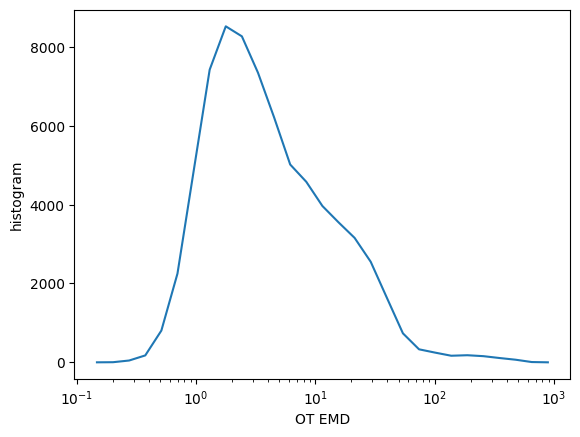

In [53]:
#review histogram of OT EMD costs to choose cutoff
ot_costs=[[np.inf]]*(np.max(indgood_models)+1)
linSets=[None]*(np.max(indgood_models)+1)
#cells_nchildren=[None]*(np.max(indgood_models)+1)
for i in indgood_models:
    print(f're-tracking {modelSet[i].h5filename}')
    sctm=modelSet[i]
    #ot_costs[i],linSets[i]=sctm.get_lineage_min_otcost(distcut=0.5*sctm.cellpose_diam,return_cost=True,ot_cost_cut=np.inf,border_resolution=1.33,visual=False,save_h5=True,overwrite=True)
    ot_costs[i]=sctm.ot_tracking_costs.copy()
    linSets[i]=sctm.linSet.copy()
    #cells_nchildren[i]=sctm.get_cells_nchildren()

ot_costs_all=np.concatenate(ot_costs)
#cells_nchildren_all=np.concatenate(cells_nchildren)
ot_hist,bins=np.histogram(ot_costs_all[np.isfinite(ot_costs_all)],bins=np.logspace(-3,10,num=30,base=2))
plt.plot(.5*bins[0:-1]+.5*bins[1:],ot_hist)
plt.xscale('log')
plt.ylabel('histogram')
plt.xlabel('OT EMD')

In [ ]:
#review tracks and segmentations by optimal control EMD (earth movers distance) metric, you can use this to help set the cutoff value ot_cut
trajl_future=0
trajl_past=1
fu=np.max(sctm.cells_frameSet-trajl_future)
fl=trajl_past
min_traj_len=1
min_size=sctm.cellpose_diam*sctm.cellpose_diam
#i_tm=np.where(np.array(tmSet)=='ctrl')[0][0]
#indmodels=np.where(inds_tmSet_models==i_tm)[0]
indmodels=indgood_models.copy()
indmodels=np.intersect1d(indmodels,indgood_models)
vals_seg_set=[None]*indmodels.size
inds_seg_set=[None]*indmodels.size
vals_track_set=[None]*indmodels.size
ot_cut=50.0
for iimodel in [1]: #range(indmodels.size):
    imodel=indmodels[iimodel]
    sctm_fate=modelSet[imodel]
    inds_track=np.where(np.logical_and(sctm_fate.ot_tracking_costs>ot_cut,np.isfinite(sctm_fate.ot_tracking_costs)))[0]
    inds_sort=np.argsort(sctm_fate.ot_tracking_costs[inds_track])
    #inds_track=np.flip(inds_track[inds_sort])
    inds_track=inds_track[inds_sort]
    indstw=np.where(np.logical_and(sctm_fate.cells_frameSet[inds_track]<fu,sctm_fate.cells_frameSet[inds_track]>fl))[0]
    inds_track=inds_track[indstw]
    print(inds_track)
    print(sctm_fate.cells_frameSet[inds_track])
    trackval_dir=f'./{date}/trackot_val_m{imodel}/'
    os.system(f'mkdir {trackval_dir}')
    vals_seg_set[iimodel],inds_seg_set[iimodel],vals_track_set[iimodel]=sctm_fate.manual_fate_validation(inds_track,'seg',restart=False,val_tracks=True,trajl_past=trajl_past,trajl_future=trajl_future,rep_channel=erk_img_channel,bf_channel=erk_img_channel,nuc_channel=nuc_img_channel,projection=True,msk_channel=cyto_msk_channel,pathto=trackval_dir,save_pic=True,boundary_expansion=[2,70,70],nuclow=90,save_h5=False,overwrite=False)

In [54]:
#break tracks based upon optimal transport EMD metric
ot_cut=10.0
for i in indgood_models:
    sctm=modelSet[i]
    inds_break=np.where(sctm.ot_tracking_costs>ot_cut)[0]
    print(f'breaking {inds_break.size} tracks from {modelSet[i].h5filename}')
    for ic in inds_break:
        iS=sctm.cells_frameSet[ic]
        sctm.linSet[iS][sctm.cells_indSet[ic]]=-1

breaking 169 tracks from /home/groups/CEDAR/copperma/dyn-cell-sys/makkawi/20241004_OS17lungInh2_RM/20241004_OS17lungInh2_RM_xy0_roi0.h5
breaking 541 tracks from /home/groups/CEDAR/copperma/dyn-cell-sys/makkawi/20241004_OS17lungInh2_RM/20241004_OS17lungInh2_RM_xy10_roi0.h5
breaking 947 tracks from /home/groups/CEDAR/copperma/dyn-cell-sys/makkawi/20241004_OS17lungInh2_RM/20241004_OS17lungInh2_RM_xy11_roi0.h5
breaking 626 tracks from /home/groups/CEDAR/copperma/dyn-cell-sys/makkawi/20241004_OS17lungInh2_RM/20241004_OS17lungInh2_RM_xy12_roi0.h5
breaking 352 tracks from /home/groups/CEDAR/copperma/dyn-cell-sys/makkawi/20241004_OS17lungInh2_RM/20241004_OS17lungInh2_RM_xy13_roi0.h5
breaking 444 tracks from /home/groups/CEDAR/copperma/dyn-cell-sys/makkawi/20241004_OS17lungInh2_RM/20241004_OS17lungInh2_RM_xy14_roi0.h5
breaking 239 tracks from /home/groups/CEDAR/copperma/dyn-cell-sys/makkawi/20241004_OS17lungInh2_RM/20241004_OS17lungInh2_RM_xy15_roi0.h5
breaking 878 tracks from /home/groups/CEDA

In [55]:
#Map all trajectories
all_trajSet=[None]*nmodels
for i in indgood_models:
    print(f'tracing trajectories for {modelSet[i].h5filename}')
    modelSet[i].get_unique_trajectories()
    all_trajSet[i]=modelSet[i].trajectories.copy()

tracing trajectories for /home/groups/CEDAR/copperma/dyn-cell-sys/makkawi/20241004_OS17lungInh2_RM/20241004_OS17lungInh2_RM_xy0_roi0.h5
tracked cell 758, 2 tracks, 600 left
tracked cell 588, 1 tracks, 500 left
tracked cell 431, 2 tracks, 300 left
tracked cell 170, 1 tracks, 100 left
tracked cell 0, 1 tracks, 0 left
tracing trajectories for /home/groups/CEDAR/copperma/dyn-cell-sys/makkawi/20241004_OS17lungInh2_RM/20241004_OS17lungInh2_RM_xy10_roi0.h5
tracked cell 1035, 3 tracks, 1000 left
tracked cell 928, 1 tracks, 900 left
tracked cell 789, 13 tracks, 700 left
tracked cell 590, 17 tracks, 500 left
tracked cell 494, 1 tracks, 400 left
tracked cell 258, 1 tracks, 200 left
tracked cell 2, 1 tracks, 0 left
tracing trajectories for /home/groups/CEDAR/copperma/dyn-cell-sys/makkawi/20241004_OS17lungInh2_RM/20241004_OS17lungInh2_RM_xy11_roi0.h5
tracked cell 1909, 1 tracks, 1700 left
tracked cell 1744, 3 tracks, 1600 left
tracked cell 1599, 1 tracks, 1500 left
tracked cell 992, 1 tracks, 800 l

### validate deaths

In [70]:
trajl_future=4
trajl_past=1
fu=np.max(sctm.cells_frameSet-trajl_future)
fl=trajl_past
min_traj_len=5
stride=4
min_size=sctm.cellpose_diam*sctm.cellpose_diam
#i_tm=np.where(np.array(tmSet)=='ctrl')[0][0]
#indmodels=np.where(inds_tmSet_models==i_tm)[0]
indmodels=indgood_models.copy()
indmodels=np.intersect1d(indmodels,indgood_models)
vals_death_set=[None]*indmodels.size
inds_death_set=[None]*indmodels.size
for iimodel in range(indmodels.size):
    imodel=indmodels[iimodel]
    sctm_fate=modelSet[imodel]
    inds_last=np.array([]).astype(int)
    for itraj in range(len(sctm_fate.trajectories)):
        ic_last=sctm_fate.trajectories[itraj][-1]
        if sctm_fate.cells_frameSet[ic_last] != np.max(sctm_fate.cells_frameSet) and sctm_fate.trajectories[itraj].size>min_traj_len:
            imgc_test,mskc_relabeled=sctm_fate.get_cell_data(ic_last,relabel_mskchannels=[cyto_msk_channel])
            size=np.sum(mskc_relabeled[...,cyto_msk_channel]==ic_last)
            print(f'cell {ic_last} size {size}, {itraj}/{len(sctm_fate.trajectories)}')
            if size>min_size:
                inds_last=np.append(inds_last,ic_last)
    indstw=np.where(np.logical_and(sctm_fate.cells_frameSet[inds_last]<fu,sctm_fate.cells_frameSet[inds_last]>fl))[0]
    inds_last=inds_last[indstw]
    print(inds_last)
    print(sctm_fate.cells_frameSet[inds_last])
    deathval_dir=f'./{date}/death_val_m{imodel}/'
    os.system(f'mkdir {deathval_dir}')
    vals_death_set[iimodel],inds_death_set[iimodel]=sctm_fate.manual_fate_validation(inds_last,'death',restart=False,val_tracks=False,trajl_past=trajl_past,trajl_future=trajl_future,stride=stride,rep_channel=erk_img_channel,bf_channel=erk_img_channel,nuc_channel=nuc_img_channel,projection=True,msk_channel=cyto_msk_channel,pathto=deathval_dir,save_pic=True,boundary_expansion=[3,70,70],nuclow=90,save_h5=True,overwrite=True)

saving attributes ['inds_death', 'vals_death', 'indreviewed_death'] to /cell_data_m0/ in /home/groups/CEDAR/copperma/dyn-cell-sys/makkawi/20241004_OS17lungInh2_RM/20241004_OS17lungInh2_RM_xy34_roi0.h5
saved inds_death to /home/groups/CEDAR/copperma/dyn-cell-sys/makkawi/20241004_OS17lungInh2_RM/20241004_OS17lungInh2_RM_xy34_roi0.h5//cell_data_m0/
saved vals_death to /home/groups/CEDAR/copperma/dyn-cell-sys/makkawi/20241004_OS17lungInh2_RM/20241004_OS17lungInh2_RM_xy34_roi0.h5//cell_data_m0/
saved indreviewed_death to /home/groups/CEDAR/copperma/dyn-cell-sys/makkawi/20241004_OS17lungInh2_RM/20241004_OS17lungInh2_RM_xy34_roi0.h5//cell_data_m0/


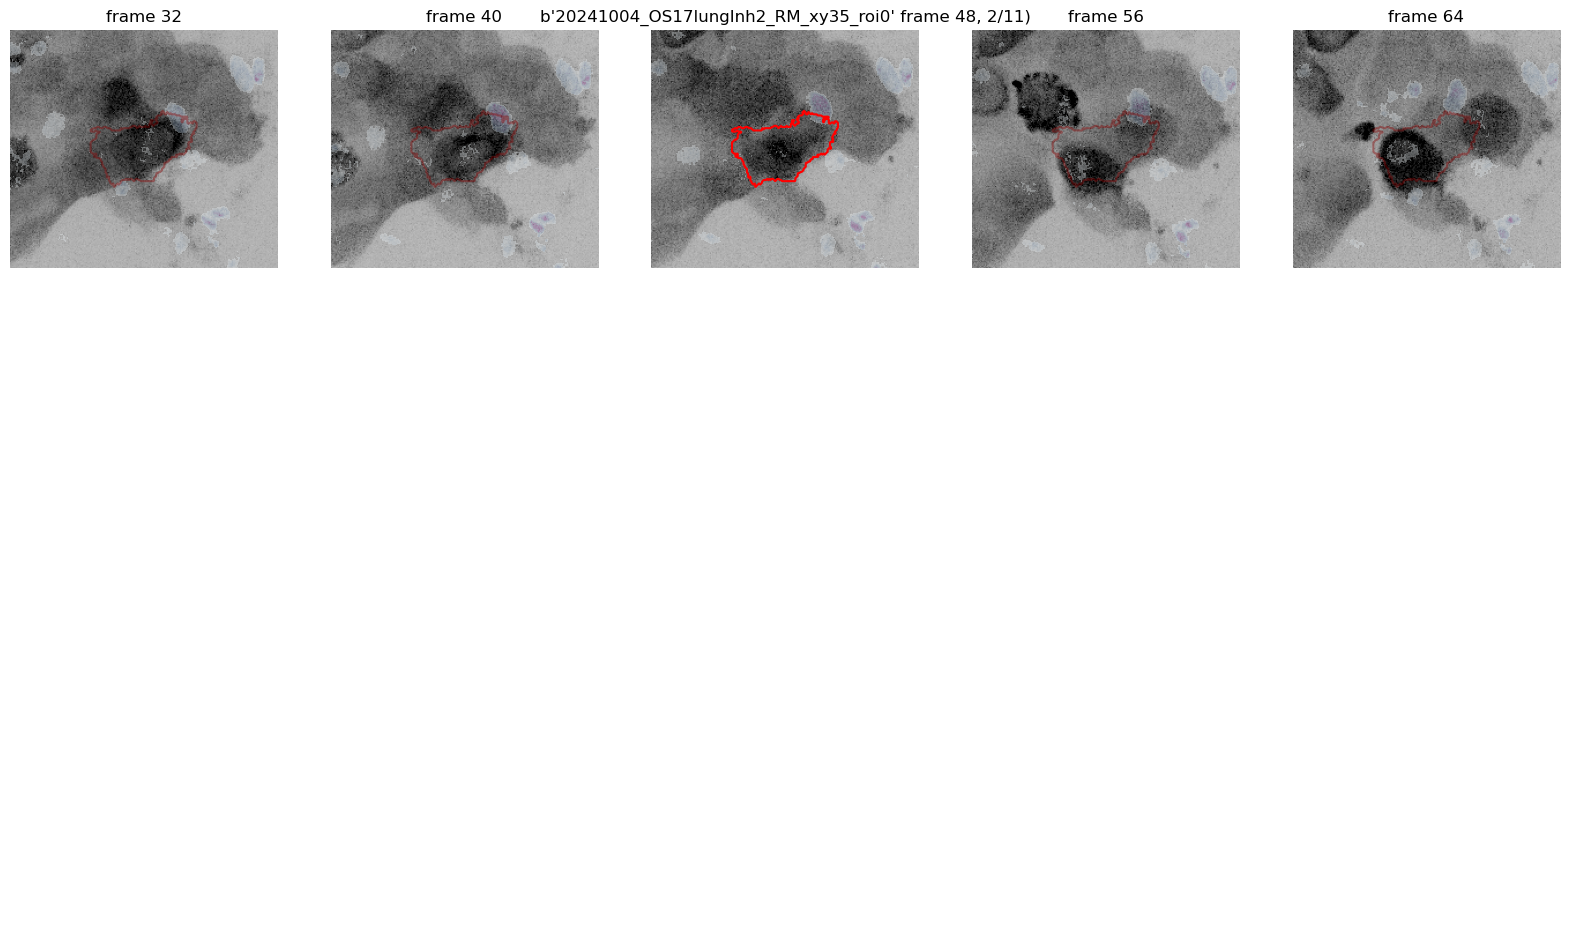

fate validation (q to quit, -1 can't tell, 0 not fate, 1 is fate):
 q


saving attributes ['inds_death', 'vals_death', 'indreviewed_death'] to /cell_data_m0/ in /home/groups/CEDAR/copperma/dyn-cell-sys/makkawi/20241004_OS17lungInh2_RM/20241004_OS17lungInh2_RM_xy35_roi0.h5
overwrote existing and saved inds_death to /home/groups/CEDAR/copperma/dyn-cell-sys/makkawi/20241004_OS17lungInh2_RM/20241004_OS17lungInh2_RM_xy35_roi0.h5//cell_data_m0/
overwrote existing and saved vals_death to /home/groups/CEDAR/copperma/dyn-cell-sys/makkawi/20241004_OS17lungInh2_RM/20241004_OS17lungInh2_RM_xy35_roi0.h5//cell_data_m0/
overwrote existing and saved indreviewed_death to /home/groups/CEDAR/copperma/dyn-cell-sys/makkawi/20241004_OS17lungInh2_RM/20241004_OS17lungInh2_RM_xy35_roi0.h5//cell_data_m0/


In [489]:
#review deaths again for a model, this does not save
imodel=1
inds_death=inds_death_set[imodel]
sctm_fate=modelSet[imodel]
deathval_dir=f'./{date}/death_test_m{imodel}/'
os.system(f'mkdir {deathval_dir}')
inds_test,vals_test=sctm_fate.manual_fate_validation(inds_death,'death',show_allcells=False,show_linked=False,val_tracks=False,restart=False,trajl_past=2,trajl_future=2,stride=8,rep_channel=erk_img_channel,bf_channel=erk_img_channel,nuc_channel=nuc_img_channel,projection=True,msk_channel=cyto_msk_channel,pathto=deathval_dir,save_pic=True,boundary_expansion=[2,70,70],nuclow=90,save_h5=False,overwrite=False)

### randomly review segmentation and tracking to determine performance

In [490]:
trajl_future=0
trajl_past=1
fu=np.max(sctm.cells_frameSet-trajl_future)
fl=trajl_past
min_traj_len=1
min_size=sctm.cellpose_diam*sctm.cellpose_diam
#i_tm=np.where(np.array(tmSet)=='ctrl')[0][0]
#indmodels=np.where(inds_tmSet_models==i_tm)[0]
indmodels=indgood_models.copy()
indmodels=np.intersect1d(indmodels,indgood_models)
vals_seg_set=[None]*indmodels.size
inds_seg_set=[None]*indmodels.size
vals_track_set=[None]*indmodels.size
n_val=20
for iimodel in range(indmodels.size):
    imodel=indmodels[iimodel]
    sctm_fate=modelSet[imodel]
    indstw=np.where(np.logical_and(sctm.cells_frameSet<fu,sctm.cells_frameSet>fl))[0]
    inds_random = np.random.choice(indstw.size, n_val, replace=False)
    inds_test=indstw[inds_random]
    trackval_dir=f'./{date}/track_val_m{imodel}/'
    os.system(f'mkdir {trackval_dir}')
    print(f'validating {n_val} segs and tracks for {sctm.figid}, writing results to {trackval_dir}')
    vals_seg_set[iimodel],inds_seg_set[iimodel],vals_track_set[iimodel]=sctm_fate.manual_fate_validation(inds_track,'seg',restart=False,val_tracks=True,trajl_past=trajl_past,trajl_future=trajl_future,rep_channel=erk_img_channel,bf_channel=erk_img_channel,nuc_channel=nuc_img_channel,projection=False,msk_channel=cyto_msk_channel,pathto=trackval_dir,save_pic=True,boundary_expansion=[2,70,70],nuclow=90,save_h5=False,overwrite=False)

[ 257 2143 1260 2059 2315 2061 1631  303  207  280 3588 2381 2566 1523
 1196 2103 2198 2924  575 3585 2625 2346  529 3286 3315  621 1984 2199
 1860 2852 1863 1121  706  315 1871  190  132 1320 3136  222  366 1940
 2521  179 1970 1180 1556 1932  708 1105 2244  834  306  267  262 1186
 1768  494 1306  949 1097 1303  136  430 3449 2871 1304 3277 3362 3485
 2012 1979 2491 1972 2757 1913 1678  364  363  540 1555 2651 1602 1103
 2585  606 2523  687]
[ 5 51 29 49 55 49 38  6  4  6 94 57 63 36 28 50 52 73 12 94 65 56 11 84
 85 13 47 52 44 71 44 26 15  6 44  4  2 31 79  4  7 46 61  3 46 27 36 45
 15 25 53 18  6  5  5 28 41 10 30 21 25 30  2  9 89 71 30 84 86 91 47 47
 60 46 68 45 39  7  7 11 36 65 38 25 63 13 61 15]


mkdir: cannot create directory ‘./21nov24/track_val_m1/’: File exists


IndexError: index -2 is out of bounds for axis 0 with size 1

### validate divisions

[81, 82]


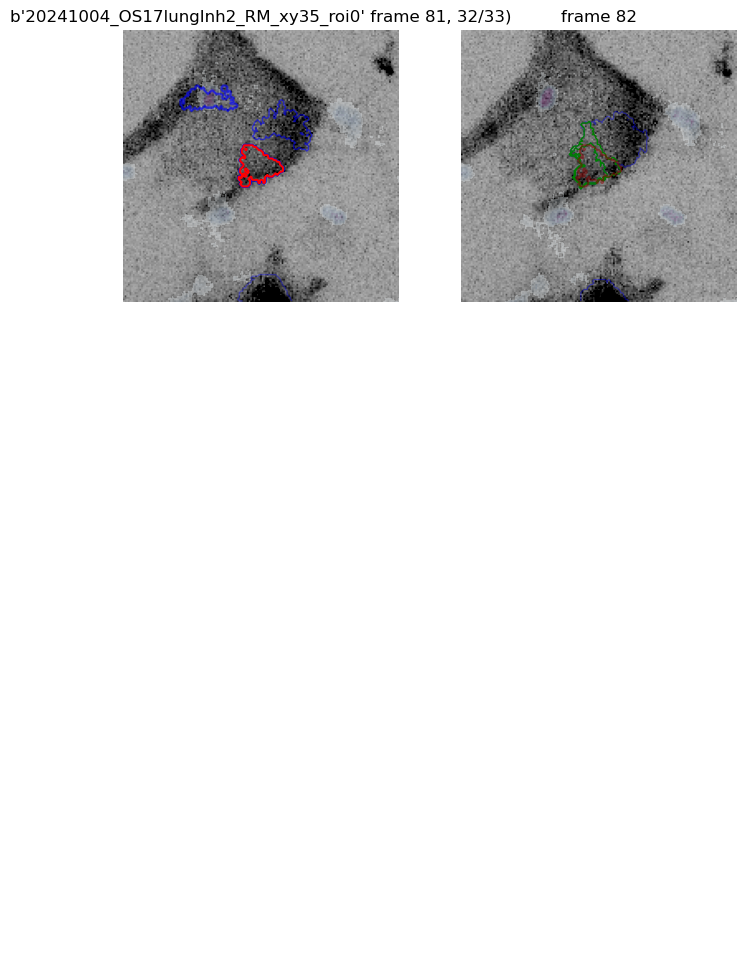

track validation (1 all good, -2 to break past link, 2 to break future link, 0 to break both):
 1
fate validation (q to quit, -1 can't tell, 0 not fate, 1 is fate):
 1


In [349]:
trajl_future=1
trajl_past=0
fu=np.max(sctm.cells_frameSet-trajl_future)
fl=trajl_past
min_traj_len=1
#i_tm=np.where(np.array(tmSet)=='ctrl')[0][0]
#indmodels=np.where(inds_tmSet_models==i_tm)[0]
indmodels=indgood_models.copy()
indmodels=np.intersect1d(indmodels,indgood_models)
vals_div_set=[None]*indmodels.size
inds_div_set=[None]*indmodels.size
vals_div_track_set=[None]*indmodels.size
for iimodel in [1]: #range(indmodels.size):
    imodel=indmodels[iimodel]
    sctm_fate=modelSet[imodel]
    cells_nchildren=sctm_fate.get_cells_nchildren()
    inds_div=np.where(cells_nchildren>1)[0]
    indstw=np.where(np.logical_and(sctm_fate.cells_frameSet[inds_div]<fu,sctm_fate.cells_frameSet[inds_div]>fl))[0]
    inds_div=inds_div[indstw]
    print(inds_div)
    print(sctm_fate.cells_frameSet[inds_div])
    div_val_dir=f'./{date}/div_val_m{imodel}/'
    os.system(f'mkdir {div_val_dir}')
    vals_div_set[iimodel],inds_div_set[iimodel],vals_div_track_set[iimodel]=sctm_fate.manual_fate_validation(inds_div,'div',restart=False,val_tracks=True,trajl_past=trajl_past,trajl_future=trajl_future,rep_channel=erk_img_channel,bf_channel=erk_img_channel,nuc_channel=nuc_img_channel,projection=True,msk_channel=cyto_msk_channel,pathto=div_val_dir,save_pic=True,boundary_expansion=[2,70,70],nuclow=90,save_h5=False,overwrite=False)

### death / persistors analysis

In [30]:
indgood_models

array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 16, 17,
       19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 33, 34, 35, 36,
       37, 38, 39, 40])

In [31]:
indmodels_death=indgood_models.copy()
nuc_fmsk_channel=1

In [58]:
#signaling features
cratio_erk=np.array([]).astype(float)
for i in indmodels_death:
    sctm=modelSet[i]
    attr_str=f'img{erk_img_channel}_m{sctm.mskchannel}m{nuc_fmsk_channel}_ratio'
    cc=getattr(sctm,attr_str)
    cratio_erk=np.append(cratio_erk,cc)
    modelSet[i].x_signal=cc.copy()

cratio_erk_std=np.std(cratio_erk);cratio_erk_mean=np.mean(cratio_erk);#cratio_erk=imprep.znorm(cratio_erk)

In [60]:
#signaling features
cratio_akt=np.array([]).astype(float)
for i in indmodels_death:
    sctm=modelSet[i]
    attr_str=f'img{akt_img_channel}_m{sctm.mskchannel}m{nuc_fmsk_channel}_ratio'
    cc=getattr(sctm,attr_str)
    cratio_akt=np.append(cratio_akt,cc)
    modelSet[i].x_signal_akt=cc.copy()

cratio_akt_std=np.std(cratio_akt);cratio_akt_mean=np.mean(cratio_akt);#cratio_erk=imprep.znorm(cratio_erk)

cell death at frame 48 traced for 15 frames
cell death at frame 39 traced for 27 frames
cell death at frame 38 traced for 7 frames
cell death at frame 29 traced for 9 frames
cell death at frame 8 traced for 9 frames
cell death at frame 91 traced for 92 frames
cell death at frame 90 traced for 12 frames
cell death at frame 77 traced for 29 frames
cell death at frame 69 traced for 6 frames
cell death at frame 60 traced for 6 frames
cell death at frame 59 traced for 7 frames
cell death at frame 55 traced for 7 frames
cell death at frame 45 traced for 46 frames
cell death at frame 44 traced for 26 frames
cell death at frame 22 traced for 23 frames
cell death at frame 20 traced for 21 frames
cell death at frame 20 traced for 7 frames
cell death at frame 17 traced for 7 frames
cell death at frame 17 traced for 9 frames
cell death at frame 13 traced for 12 frames
cell death at frame 10 traced for 7 frames
cell death at frame 10 traced for 7 frames
cell death at frame 9 traced for 10 frames
ce

NameError: name 'erk_trajs_initial' is not defined

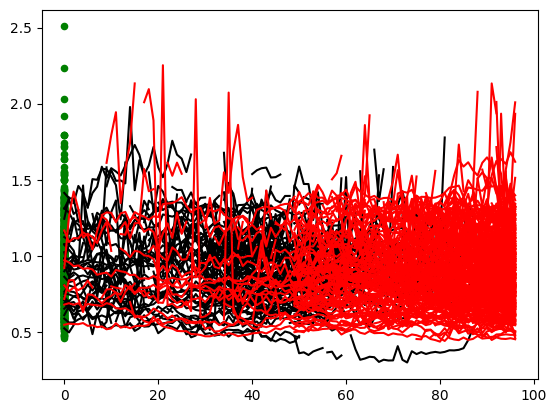

In [71]:
erk_trajs_death=[]
for imodel in indmodels_death:
    sctm=modelSet[imodel]
    for ideath in range(sctm.inds_death.size):
        ic=sctm.inds_death[ideath]
        cell_traj=sctm.get_cell_trajectory(ic)
        print(f'cell death at frame {sctm.cells_frameSet[ic]} traced for {cell_traj.size} frames')
        frames=sctm.cells_frameSet[cell_traj]
        erk_traj=sctm.x_signal[cell_traj]
        xtraj=np.ones(sctm.nt)*np.nan
        xtraj[frames]=erk_traj
        erk_trajs_death.append(xtraj)
        plt.plot(frames,erk_traj,color='black')

erk_trajs_persist=[]
for imodel in indmodels_death:
    sctm=modelSet[imodel]
    inds_persistors=np.where(sctm.cells_frameSet==np.max(sctm.cells_frameSet))[0]
    for ipersist in range(inds_persistors.size):
        ic=inds_persistors[ipersist]
        cell_traj=sctm.get_cell_trajectory(ic)
        print(f'cell death at frame {sctm.cells_frameSet[ic]} traced for {cell_traj.size} frames')
        frames=sctm.cells_frameSet[cell_traj]
        erk_traj=sctm.x_signal[cell_traj]
        xtraj=np.ones(sctm.nt)*np.nan
        xtraj[frames]=erk_traj
        erk_trajs_persist.append(xtraj)
        plt.plot(frames,erk_traj,color='red')

erk_initial=np.array([])
for imodel in indmodels_death:
    sctm=modelSet[imodel]
    inds_initial=np.where(sctm.cells_frameSet==0)[0]
    erk_initial=np.append(erk_initial,sctm.x_signal[inds_initial])

erk_initial=np.array(erk_initial)
plt.scatter(np.zeros_like(erk_initial),erk_initial,s=20,c='green',marker='o')

erk_trajs_persist=np.array(erk_trajs_persist)
erk_trajs_death=np.array(erk_trajs_death)
erk_trajs_initial=np.array(erk_trajs_initial)

In [74]:
date='15dec25'
os.system(f'mkdir {date}')

0

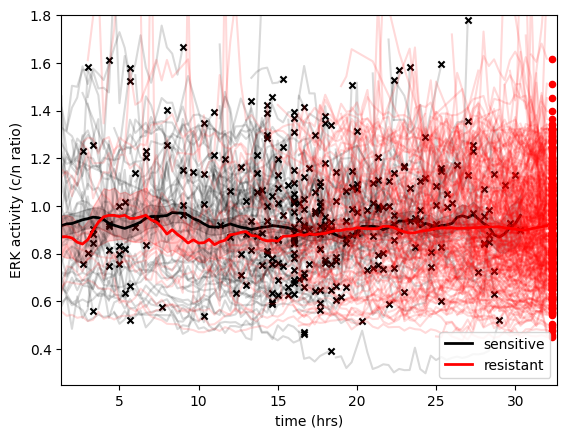

In [75]:
sys.path.append('/home/groups/ZuckermanLab/copperma/msmWE/BayesianBootstrap')
import bootstrap
import bootstrapN
scipy.average=np.mean
scipy.percentile=np.percentile
plt.figure()
ax=plt.gca()
fw=4
nframes=sctm.nt
timestep=.3333
x_means_death=np.ones(nframes)*np.nan
x_bounds_death=np.ones((nframes,2))*np.nan
for iframe in range(fw,nframes):
    fwindow=np.arange(iframe-fw,iframe).astype(int)
    xs=erk_trajs_death[:,fwindow].flatten()
    xs=xs[np.isfinite(xs)]
    if xs.size>10:
        x_bounds_death[iframe,:]=bootstrap.get_CI(xs,1000)
        x_means_death[iframe]=np.nanmean(xs)

for itraj in range(len(erk_trajs_death)):
    frames=np.where(np.isfinite(erk_trajs_death[itraj,:]))[0]
    if frames.size>0:
        ax.plot(frames*timestep,erk_trajs_death[itraj,frames],'-',color='black',alpha=.15)
        ax.scatter([frames[-1]*timestep],[erk_trajs_death[itraj,frames[-1]]],s=20,c='black',marker='x')

ax.plot(np.arange(nframes)*timestep,x_means_death,'-',color='black',linewidth=2,label='sensitive')
ax.fill_between(np.arange(nframes)*timestep,x_bounds_death[:,0],x_bounds_death[:,1],color='black',alpha=.2)

x_means_persist=np.ones(nframes)*np.nan
x_bounds_persist=np.ones((nframes,2))*np.nan
for iframe in range(fw,nframes):
    fwindow=np.arange(iframe-fw,iframe).astype(int)
    xs=erk_trajs_persist[:,fwindow].flatten()
    xs=xs[np.isfinite(xs)]
    if xs.size>10:
        x_bounds_persist[iframe,:]=bootstrap.get_CI(xs,1000)
        x_means_persist[iframe]=np.nanmean(xs)

for itraj in range(len(erk_trajs_persist)):
    ax.plot(np.where(np.isfinite(erk_trajs_persist[itraj,:]))[0]*timestep,erk_trajs_persist[itraj,np.where(np.isfinite(erk_trajs_persist[itraj,:]))[0]],'-',color='red',alpha=.15)
    ax.scatter([nframes*timestep],[erk_trajs_persist[itraj,-1]],s=20,c='red',marker='o')
    
ax.plot(np.arange(nframes)*timestep,x_means_persist,'-',color='red',linewidth=2,label='resistant')
ax.fill_between(np.arange(nframes)*timestep,x_bounds_persist[:,0],x_bounds_persist[:,1],color='red',alpha=.2)

#plt.scatter(np.ones_like(erk_initial),erk_initial,s=20,c='green',marker='o')

plt.ylabel('ERK activity (c/n ratio)')
plt.xlabel('time (hrs)')
plt.ylim(.25,1.8)
plt.xlim(fw*timestep,(nframes+1)*timestep)
plt.legend(loc='lower right') #(bbox_to_anchor=(1.1, 1.0))
plt.savefig(f'{date}/erk_activity_dead_alive.png')

In [112]:
frames_death=[]
erk_death=[]
akt_death=[]
lungf_death=[]
cc_death=[]
for imodel in indmodels_death:
    sctm=modelSet[imodel]
    for ideath in range(sctm.inds_death.size):
        ic=sctm.inds_death[ideath]
        frames_death.append(sctm.cells_frameSet[ic])
        erk_death.append(sctm.x_signal[ic])
        akt_death.append(sctm.x_signal_akt[ic])
        indboundary=np.where(sctm.boundary_library['global_index']==ic)[0]
        rdx_cc=np.linalg.norm(sctm.boundary_library['nn_pts_states'][indboundary,1,:]-sctm.boundary_library['pts'][indboundary,:],axis=1)
        rdx_lung=np.linalg.norm(sctm.boundary_library['nn_pts_states'][indboundary,3,:]-sctm.boundary_library['pts'][indboundary,:],axis=1)
        lungf_death.append(np.nanmean(rdx_lung))
        cc_death.append(np.nanmean(rdx_cc))
        
frames_persist=[]
erk_persist=[]
akt_persist=[]
lungf_persist=[]
cc_persist=[]
for imodel in indmodels_death:
    sctm=modelSet[imodel]
    inds_persistors=np.where(sctm.cells_frameSet==np.max(sctm.cells_frameSet))[0]
    for ipersist in range(inds_persistors.size):
        ic=inds_persistors[ipersist]
        frames_persist.append(sctm.cells_frameSet[ic])
        erk_persist.append(sctm.x_signal[ic])
        akt_persist.append(sctm.x_signal_akt[ic])
        indboundary=np.where(sctm.boundary_library['global_index']==ic)[0]
        rdx_cc=np.linalg.norm(sctm.boundary_library['nn_pts_states'][indboundary,1,:]-sctm.boundary_library['pts'][indboundary,:],axis=1)
        rdx_lung=np.linalg.norm(sctm.boundary_library['nn_pts_states'][indboundary,3,:]-sctm.boundary_library['pts'][indboundary,:],axis=1)
        lungf_persist.append(np.nanmean(rdx_lung))
        cc_persist.append(np.nanmean(rdx_cc))

frames_initial=[]
erk_initial=[]
akt_initial=[]
lungf_initial=[]
cc_initial=[]
for imodel in indmodels_death:
    sctm=modelSet[imodel]
    inds_initial=np.where(sctm.cells_frameSet==0)[0]
    for icell in range(inds_initial.size):
        ic=inds_initial[icell]
        frames_initial.append(sctm.cells_frameSet[ic])
        erk_initial.append(sctm.x_signal[ic])
        akt_initial.append(sctm.x_signal_akt[ic])
        indboundary=np.where(sctm.boundary_library['global_index']==ic)[0]
        rdx_cc=np.linalg.norm(sctm.boundary_library['nn_pts_states'][indboundary,1,:]-sctm.boundary_library['pts'][indboundary,:],axis=1)
        rdx_lung=np.linalg.norm(sctm.boundary_library['nn_pts_states'][indboundary,3,:]-sctm.boundary_library['pts'][indboundary,:],axis=1)
        lungf_initial.append(np.nanmean(rdx_lung))
        cc_initial.append(np.nanmean(rdx_cc))

/tmp/ipykernel_3445915/206265988.py:16: RuntimeWarning: Mean of empty slice
  lungf_death.append(np.nanmean(rdx_lung))
/tmp/ipykernel_3445915/206265988.py:35: RuntimeWarning: Mean of empty slice
  lungf_persist.append(np.nanmean(rdx_lung))
/tmp/ipykernel_3445915/206265988.py:55: RuntimeWarning: Mean of empty slice
  cc_initial.append(np.nanmean(rdx_cc))


In [110]:
imodel

33

In [111]:
indgood_models=indgood_models[np.where(indgood_models!=33)[0]]
indmodels_death=indgood_models.copy()

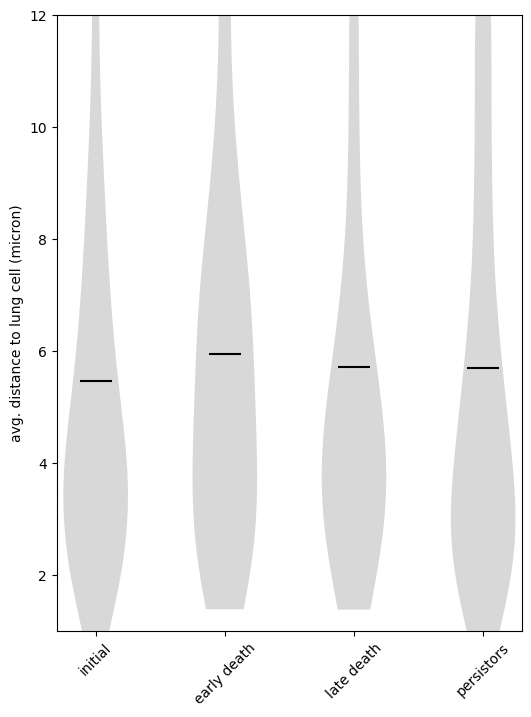

In [113]:
framecut_early=50
fig=plt.figure(figsize=(6,8))
ax=plt.gca()
setv=np.array(lungf_initial)/sctm.boundary_library['border_resolution']
vplot=ax.violinplot(setv[np.isfinite(setv)],positions=[0],showmeans=True,showextrema=False) #,quantiles=[.05,.95])
vplot['cmeans'].set_color('black')
for pc in vplot['bodies']:
    pc.set_facecolor('gray')

inds_early=np.where(np.array(frames_death)<framecut_early)[0]
setv=np.array(lungf_death)[inds_early]/sctm.boundary_library['border_resolution']
vplot=ax.violinplot(setv[np.isfinite(setv)],positions=[1],showmeans=True,showextrema=False) #,quantiles=[.05,.95])
vplot['cmeans'].set_color('black')
for pc in vplot['bodies']:
    pc.set_facecolor('gray')

inds_late=np.where(np.array(frames_death)>=framecut_early)[0]
setv=np.array(lungf_death)[inds_late]/sctm.boundary_library['border_resolution']
vplot=ax.violinplot(setv[np.isfinite(setv)],positions=[2],showmeans=True,showextrema=False) #,quantiles=[.05,.95])
vplot['cmeans'].set_color('black')
for pc in vplot['bodies']:
    pc.set_facecolor('gray')

setv=np.array(lungf_persist)/sctm.boundary_library['border_resolution']
vplot=ax.violinplot(setv[np.isfinite(setv)],positions=[3],showmeans=True,showextrema=False) #,quantiles=[.05,.95])
vplot['cmeans'].set_color('black')
for pc in vplot['bodies']:
    pc.set_facecolor('gray')

ax.set_xlim(-.3,3.3)
ax.set_ylim(1,12)
ax.set_xticks(range(0,3+1))
ax.set_xticklabels(['initial','early death','late death','persistors'],rotation=45)
ax.set_ylabel('avg. distance to lung cell (micron)')
plt.savefig(f'{date}/lung_contact_earlylate.png')

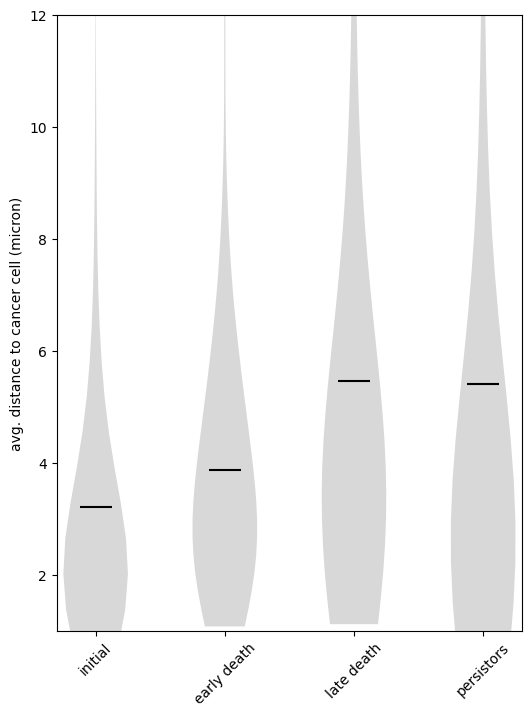

In [116]:
framecut_early=50
fig=plt.figure(figsize=(6,8))
ax=plt.gca()
setv=np.array(cc_initial)/sctm.boundary_library['border_resolution']
vplot=ax.violinplot(setv[np.isfinite(setv)],positions=[0],showmeans=True,showextrema=False) #,quantiles=[.05,.95])
vplot['cmeans'].set_color('black')
for pc in vplot['bodies']:
    pc.set_facecolor('gray')

inds_early=np.where(np.array(frames_death)<framecut_early)[0]
setv=np.array(cc_death)[inds_early]/sctm.boundary_library['border_resolution']
vplot=ax.violinplot(setv[np.isfinite(setv)],positions=[1],showmeans=True,showextrema=False) #,quantiles=[.05,.95])
vplot['cmeans'].set_color('black')
for pc in vplot['bodies']:
    pc.set_facecolor('gray')

inds_late=np.where(np.array(frames_death)>=framecut_early)[0]
setv=np.array(cc_death)[inds_late]/sctm.boundary_library['border_resolution']
vplot=ax.violinplot(setv[np.isfinite(setv)],positions=[2],showmeans=True,showextrema=False) #,quantiles=[.05,.95])
vplot['cmeans'].set_color('black')
for pc in vplot['bodies']:
    pc.set_facecolor('gray')

setv=np.array(cc_persist)/sctm.boundary_library['border_resolution']
vplot=ax.violinplot(setv[np.isfinite(setv)],positions=[3],showmeans=True,showextrema=False) #,quantiles=[.05,.95])
vplot['cmeans'].set_color('black')
for pc in vplot['bodies']:
    pc.set_facecolor('gray')

ax.set_xlim(-.3,3.3)
ax.set_ylim(1,12)
ax.set_xticks(range(0,3+1))
ax.set_xticklabels(['initial','early death','late death','persistors'],rotation=45)
ax.set_ylabel('avg. distance to cancer cell (micron)')
plt.savefig(f'{date}/cancer_contact_earlylate.png')

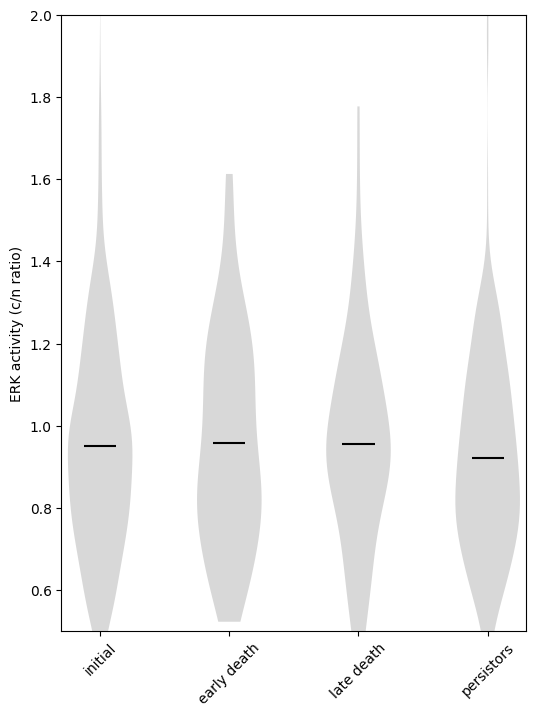

In [117]:
framecut_early=50
fig=plt.figure(figsize=(6,8))
ax=plt.gca()
setv=np.array(erk_initial)
vplot=ax.violinplot(setv[np.isfinite(setv)],positions=[0],showmeans=True,showextrema=False) #,quantiles=[.05,.95])
vplot['cmeans'].set_color('black')
for pc in vplot['bodies']:
    pc.set_facecolor('gray')

inds_early=np.where(np.array(frames_death)<framecut_early)[0]
setv=np.array(erk_death)[inds_early]
vplot=ax.violinplot(setv[np.isfinite(setv)],positions=[1],showmeans=True,showextrema=False) #,quantiles=[.05,.95])
vplot['cmeans'].set_color('black')
for pc in vplot['bodies']:
    pc.set_facecolor('gray')

inds_late=np.where(np.array(frames_death)>=framecut_early)[0]
setv=np.array(erk_death)[inds_late]
vplot=ax.violinplot(setv[np.isfinite(setv)],positions=[2],showmeans=True,showextrema=False) #,quantiles=[.05,.95])
vplot['cmeans'].set_color('black')
for pc in vplot['bodies']:
    pc.set_facecolor('gray')

setv=np.array(erk_persist)
vplot=ax.violinplot(setv[np.isfinite(setv)],positions=[3],showmeans=True,showextrema=False) #,quantiles=[.05,.95])
vplot['cmeans'].set_color('black')
for pc in vplot['bodies']:
    pc.set_facecolor('gray')

ax.set_xlim(-.3,3.3)
ax.set_ylim(.5,2)
ax.set_xticks(range(0,3+1))
ax.set_xticklabels(['initial','early death','late death','persistors'],rotation=45)
ax.set_ylabel('ERK activity (c/n ratio)')
plt.savefig(f'{date}/erk_activity_earlylate.png')

cell death at frame 48 traced for 15 frames
cell death at frame 39 traced for 27 frames
cell death at frame 38 traced for 7 frames
cell death at frame 29 traced for 9 frames
cell death at frame 8 traced for 9 frames
cell death at frame 91 traced for 92 frames
cell death at frame 90 traced for 12 frames
cell death at frame 77 traced for 29 frames
cell death at frame 69 traced for 6 frames
cell death at frame 60 traced for 6 frames
cell death at frame 59 traced for 7 frames
cell death at frame 55 traced for 7 frames
cell death at frame 45 traced for 46 frames
cell death at frame 44 traced for 26 frames
cell death at frame 22 traced for 23 frames
cell death at frame 20 traced for 21 frames
cell death at frame 20 traced for 7 frames
cell death at frame 17 traced for 7 frames
cell death at frame 17 traced for 9 frames
cell death at frame 13 traced for 12 frames
cell death at frame 10 traced for 7 frames
cell death at frame 10 traced for 7 frames
cell death at frame 9 traced for 10 frames
ce

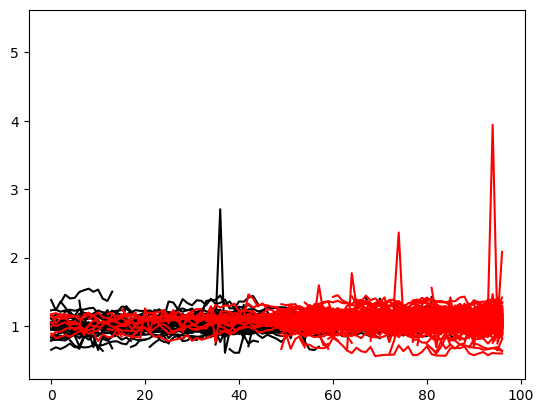

In [115]:
for imodel in indmodels_death:
    sctm=modelSet[imodel]
    for ideath in range(sctm.inds_death.size):
        ic=sctm.inds_death[ideath]
        cell_traj=sctm.get_cell_trajectory(ic)
        print(f'cell death at frame {sctm.cells_frameSet[ic]} traced for {cell_traj.size} frames')
        frames=sctm.cells_frameSet[cell_traj]
        akt_traj=sctm.x_signal_akt[cell_traj]
        plt.plot(frames,akt_traj,color='black')

for imodel in indmodels_death:
    sctm=modelSet[imodel]
    inds_persistors=np.where(sctm.cells_frameSet==np.max(sctm.cells_frameSet))[0]
    for ipersist in range(inds_persistors.size):
        ic=inds_persistors[ipersist]
        cell_traj=sctm.get_cell_trajectory(ic)
        print(f'cell death at frame {sctm.cells_frameSet[ic]} traced for {cell_traj.size} frames')
        frames=sctm.cells_frameSet[cell_traj]
        akt_traj=sctm.x_signal_akt[cell_traj]
        plt.plot(frames,akt_traj,color='red')